# 에스티메이터
## 3. 부스트된 트리
### 참고사이트 : https://www.tensorflow.org/tutorials/estimator/boosted_trees?hl=ko

In [3]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt

# Load dataset(타이타닉 data 활용)
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [4]:
import tensorflow as tf
tf.random.set_seed(123)

In [5]:
# 데이터 확인하기
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [6]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [7]:
# dftrain(학습데이터)은 627개의 data를,
# dfeval(평가데이터)은 264개의 data를 가지고 있음.
dftrain.shape[0], dfeval.shape[0]

(627, 264)

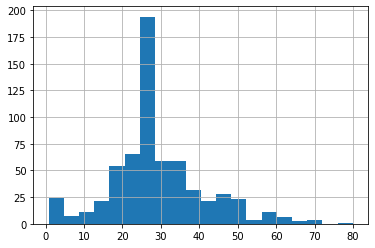

In [8]:
# 나이를 기준으로 histogram을 그려보면 주요 승객은 20~30대
dftrain.age.hist(bins=20) 
plt.show()

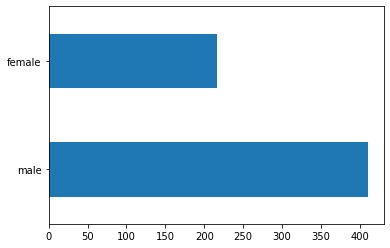

In [9]:
# 성별을 기준으로 가로 막대그래프를 그려보면 남자 손님이 여자 손님보다 약 2배 많음
dftrain.sex.value_counts().plot(kind='barh')
plt.show()

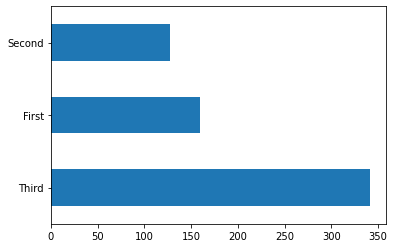

In [10]:
# class를 기준으로 가로 막대그래프를 그려보면 3등석 > 1등석 > 2등석 순
dftrain['class'].value_counts().plot(kind='barh')
plt.show()

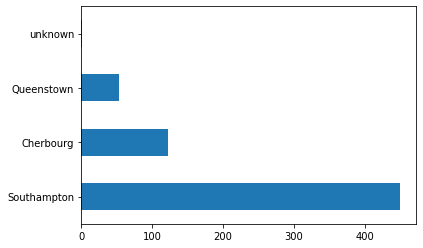

In [11]:
# embark_town(승선마을)를 기준으로 가로 막대그래프를 그려보면 Southampton에서 가장 많이 승선함
dftrain['embark_town'].value_counts().plot(kind='barh')
plt.show()

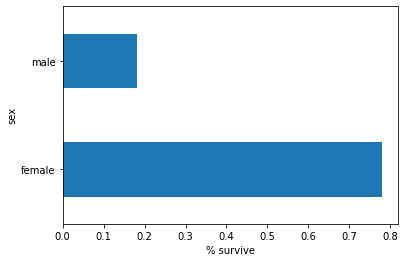

In [12]:
# 남자 승객보다 여자 승객의 생존 확률이 약 4배 높음
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')
plt.show()

In [16]:
# Feature column 및 input function 작성
# Gradient Boosting estimator는 수치형, 범주형 기능 모두 사용 가능.
# one-hot-encoding, normalization, bucketization과 같은 기능 제공.
# 이 학습서에서의 필드는 범주형 열에서 one_hot_encoding 열로 변환.
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone'] # 범주형
NUMERIC_COLUMNS = ['age', 'fare'] # 수치형

def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

In [17]:
feature_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town',

In [18]:
# indicator_column 예제(dftrain 값 중 가장 첫번째 것으로 테스트)
example = dict(dftrain.head(1))
class_fc = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('class', ('First', 'Second', 'Third')))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature value: "Third"
One-hot encoded:  [[0. 0. 1.]]


In [19]:
# 모든 feature_column을 볼 수 있음
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

In [20]:
# 입력 함수 만들기
# 훈련과 추론을 위해 데이터를 모델로 읽는 방법을 지정
# from_tensor_slices 메소드를 사용해 tf.data에서 직접 데이터 읽음
# 메모리가 작은 dataset에 적합

# 작은 dataset이기 때문에 모든 batch 사용
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [22]:
# 모델 훈련(학습) => 선형모델(linear / logistic regression model)
# 1) 기능 및 하이퍼 파라미터를 지정해 모델 초기화
# 2) 학습 데이터를 모델에 공급하고 train_input_fn을 사용해 모델 학습
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpx_cfvz4h', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and 

In [23]:
# 모델 평가
# 3) dfeval 평가 dataset을 활용해 모델의 성능 평가(예측값이 y_eval 배열과 일치하는지 확인)
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


In [26]:
# Boosted Tree 모델 학습 및 평가
# 부스트 트리는 회귀(BoostedTreesRegressor)와 분류(BoostedTreesClassifier)가 지원됨.
# 목표는 승객의 생존을 예측하는 것이므로 BoostedTreesClassifier 사용.

# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset.
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.818182
accuracy_baseline         0.625000
auc                       0.876492
auc_precision_recall      0.857622
average_loss              0.411140
label/mean                0.375000
loss                      0.411140
precision                 0.780220
prediction/mean           0.370969
recall                    0.717172
global_step             100.000000
dtype: float64


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphpcr1duk/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


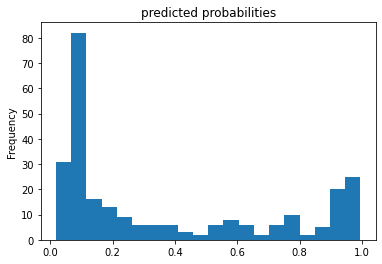

In [28]:
# 학습된 모델을 가지고 eval_input_fn(평가데이터)의 승객 예측
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

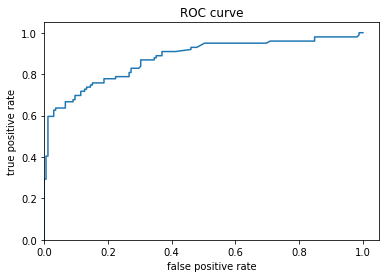

In [29]:
# 마지막으로 결과에 대해 ROC(수신자 동작 특성) 곡선 그려보기
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

같은 모델을 학습하더라도 **방법에 따라 결과가 다른 것**을 알 수 있는 예제.

선형 모델의 경우 정확도가 77%, 손실율이 48% 나왔지만,   
Gradient Boosting 모델은 정확도가 82%, 손실율이 41% 나옴.

**최종적으로 ROC 곡선의 모양도 Boosting Tree 모델이 더 좋은 것**을 알 수 있음!